# Clustering

# Índice 
1. [Introduction](#introduction)
2. [Import Materials](#importmaterials)    
    2.1. [Import Libraries](#importlibraries)     
    2.2. [Import the dataset](#importdataset)
3. [Clusterings](#clustering)    
    3.1. [Hierarchical Clustering](#hierarchical)   
    3.2. [K Means](#kmeans)     
    3.3. [SOM](#som)   
    3.4. [Mean Shift Clustering](#mean)    
    3.5. [DBSCAN](#dbscan)         
    3.6. [Gaussian Mixure Model](#gmm)  

<hr>
<a class="anchor" id="introduction">
    
# 1. Introduction
    
</a>


This notebook analyzes customer data from ABCDEats Inc., a fictional food delivery service, over three months. The goal is to create clusters of customers and make different marketing startegies for each of them....    
**Project by** Dinis Pinto (20240612), Joana Rodrigues (20240603), João Marques (20240656), and Mara Simões (20240326) - **Group 27**.

<hr>
<a class="anchor" id="importmaterials">
    
# 2. Import Materials
    
</a>

<hr>
<a class="anchor" id="importlibraries">
    
## 2.1. Import Libraries
    
</a>

For this project, we'll install some helpful libraries to make analysis easier and add features like better plotting, data handling, and modeling tools. For example, `matplotlib` and `seaborn` allow us to create clear, customizable plots, while `pandas` and `numpy` make data processing smoother.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.impute import KNNImputer
from minisom import MiniSom
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
import pickle
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, fcluster
from matplotlib.patches import RegularPolygon
import matplotlib.colors as mpl_colors
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colorbar import Colorbar
from sklearn.cluster import estimate_bandwidth, MeanShift
import matplotlib.cm as cm
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.cluster.hierarchy import dendrogram

<hr>
<a class="anchor" id="importdataset">
    
## 2.2. Import Dataset
    
</a>

### Data in dataset
The different columns in the dataset give out the following information:   
- `customer_id` - Unique identifier for each customer.
- `customer_region` - Geographic region where the customer is located.
- `customer_age` - Age of the customer.
- `vendor_count` - Number of unique vendors the customer has ordered from.
- `product_count` - Total number of products the customer has ordered.
- `is_chain` - Indicates whether the customer’s order was from a chain restaurant.
- `first_order` - Number of days from the start of the dataset when the customer first placed an order.
- `last_order` - Number of days from the start of the dataset when the customer most recently placed an order.
- `last_promo` - The category of the promotion or discount most recently used by the customer.
- `payment_method` - Method most recently used by the customer to pay for their orders.
- `CUI_American`, `CUI_Asian`, `CUI_Chinese`, `CUI_Italian`... - The amount in monetary units spent by the customer from the indicated type of cuisine. 
- `DOW_0` to `DOW_6` - Number of orders placed on each day of the week (0 = Sunday, 6 = Saturday).
- `HR_0` to `HR_23` - Number of orders placed during each hour of the day (0 = midnight, 23 = 11 PM).

In [2]:
df_preferences = pickle.load(open("df_preferences.pkl", 'rb'))

<hr>
<a class="anchor" id="clustering">
    
# 3. Clustering Algorithms
    
</a>

<a class="anchor" id="hierarchical">

## 3.1. Hierarchical Clustering
</a>

Hierarchical clustering is used to group similar data points into clusters based on similarity. It forms a hierarchical structure known as a dendrogram where we can visualize how clusters are combined or separated at each step. 

We start by define the best linkage method and plot the dendogram to choose the optimal number of clusters. To help decide the optimal number of clusters, we compared the mean values of the variables and used the silhouette score.

### Function for plotting R2 for various hierarchical methods

In [29]:
def get_ss(df): # Calculation of total sum squared
    ss = np.sum(df.var() * (df.count() - 1))
    return ss 

# ------------------------------------------------------------------
def get_ssb(df, label_col):  # sum of squares between groups (SSB)
    ssb_i = 0
    for i in np.unique(df[label_col]):
        df_ = df.drop(columns=[label_col])  # Drop the label column to include all other features
        X_ = df_.values
        X_k = df_.loc[df[label_col] == i].values
        ssb_i += (X_k.shape[0] * (np.square(X_k.mean(axis=0) - X_.mean(axis=0))) )
    ssb = np.sum(ssb_i)
    return ssb

# ------------------------------------------------------------------
def get_ssw(df, feats, label_col): # sum of squares within groups (SSW)
    feats_label = feats+[label_col]
    df_k = df[feats_label].groupby(by=label_col).apply(lambda col: get_ss(col), include_groups=False)
    return df_k.sum()

# ------------------------------------------------------------------
def get_r2(df, feats, label_col): #  R-squared value (measures the proportion of variance explained by the grouping or clustering).
    sst = get_ss(df)                 
    ssw = get_ssw(df, feats, label_col)     
    ssb = sst - ssw              
    return (ssb/sst)

# ------------------------------------------------------------------
def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"): # R² for different numbers of clusters using hierarchical clustering
    
    r2 = []  
    feats = df.columns.tolist()
    
    for i in range(min_nclus, max_nclus+1):  
        cluster = AgglomerativeClustering(n_clusters=i, metric=dist, linkage=link_method)
        hclabels = cluster.fit_predict(df) 
        df_concat = pd.concat([df, pd.Series(hclabels, name='labels', index=df.index)], axis=1)  
        r2.append(get_r2(df_concat, feats, 'labels'))
        
    return np.array(r2)

In [4]:
from sklearn.metrics import silhouette_score

def silhouette(df, labels):
    return silhouette_score(df, labels, metric='euclidean')

In [5]:
def get_r2_kmeans(df, max_nclus, min_nclus=1, random_state=42):    
    r2 = []  # where we will store the R2 metrics for each cluster solution
    feats = df.columns.tolist()
    
    for i in range(min_nclus, max_nclus+1):  # iterate over desired ncluster range
        kmeans = KMeans(n_clusters=i, random_state=random_state)
        
        # get cluster labels
        labels = kmeans.fit_predict(df)
        
        # concat df with labels
        df_concat = pd.concat([df, pd.Series(labels, name='labels', index=df.index)], axis=1)
        
        # append the R2 of the given cluster solution
        r2.append(get_r2(df_concat, feats, 'labels'))
        
    return np.array(r2)

### Defining the best linkage method and the best partitioning method (based on the R2)

In [ ]:
# Visualizing the R² scores for each hierarchical method

hc_methods = ["ward", "complete", "average", "single"]
max_nclus = 5

r2_hc = np.vstack([get_r2_hc(df_preferences, link, max_nclus=max_nclus, min_nclus=1, dist="euclidean") for link in hc_methods])

r2_hc_methods = pd.DataFrame(r2_hc.T, index=range(1, max_nclus + 1), columns=hc_methods)

sns.set()

fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)

fig.suptitle("$R^2$ plot for various hierarchical methods", fontsize=21)

plt.show()

#### With best hierarchical linkage (Ward), plot the dendogram and chose the optimal number of clusters to use

In [ ]:
linkage = 'ward'
distance = 'euclidean'

hclust = AgglomerativeClustering(linkage=linkage, metric=distance, distance_threshold=0, n_clusters=None)
hc_labels = hclust.fit_predict(df_preferences)
hc_labels

In [ ]:
# create the counts of samples under each node (number of points being merged)

from scipy.cluster.hierarchy import dendrogram

counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

for i, merge in enumerate(hclust.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1 
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

sns.set()
fig = plt.figure(figsize=(11,5))
y_threshold = 149
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering Dendrogram: {linkage.title()} Linkage', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

#### Create a hierarchical clustering algorithm and compare the mean values of the variables

In [ ]:
# n_clusters = 3

hc3_clust = AgglomerativeClustering(linkage='ward', metric='euclidean', n_clusters=3)
hc3_labels = hc3_clust.fit_predict(df_preferences)

df_concat = pd.concat([df_preferences, pd.Series(hc3_labels, name='hierarc_labels', index=df_preferences.index)], axis=1)
df_concat.groupby('hierarc_labels').mean()

In [ ]:
# n_clusters = 4

hc4_clust = AgglomerativeClustering(linkage='ward', metric='euclidean', n_clusters=4)
hc4_labels = hc4_clust.fit_predict(df_preferences)

df_concat = pd.concat([df_preferences, pd.Series(hc4_labels, name='hierarc_labels', index=df_preferences.index)], axis=1)
df_concat.groupby('hierarc_labels').mean()

In [ ]:
# n_clusters = 5

hc5_clust = AgglomerativeClustering(linkage='ward', metric='euclidean', n_clusters=5)
hc5_labels = hc5_clust.fit_predict(df_preferences)

df_concat = pd.concat([df_preferences, pd.Series(hc5_labels, name='hierarc_labels', index=df_preferences.index)], axis=1)
df_concat.groupby('hierarc_labels').mean()

#### Silhouette Score

The silhouette score define how-well separated the clusters are, indicating with a higher score the better clusters.

In [ ]:
from sklearn.metrics import silhouette_score

# Compute silhouette score for different n_clusters
for n_clusters in [3, 4, 5]:
    hc_clust = AgglomerativeClustering(linkage='ward', metric='euclidean', n_clusters=n_clusters)
    labels = hc_clust.fit_predict(df_preferences)
    silhouette_avg = silhouette_score(df_preferences, labels)
    print(f"Silhouette Score for {n_clusters} clusters: {silhouette_avg}")

#### Final Hierarchical clustering solution

<a class="anchor" id="kmeans">

## 3.2. K-Means Algorithm
</a>

#### 1. Defining the number of clusters - Inertia

Measure the inertia: sum of squared distances between the data points and the centroids - Sum of Squares within the cluster

In [30]:
range_clusters = range(1, 11)    # test between 1 and 10 clusters
inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(df_preferences)
    inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution

The inertia plot: Plot the results of testing different values of K for K-means

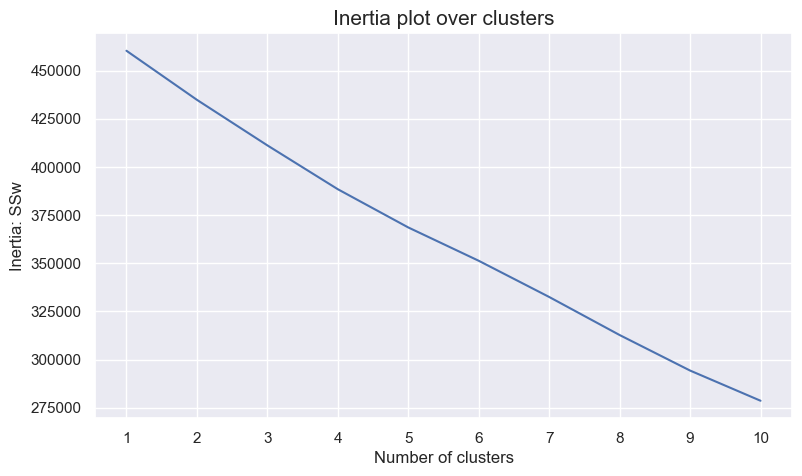

In [31]:
fig, ax = plt.subplots(figsize=(9,5))

ax.plot(range_clusters, inertia)
ax.set_xticks(range_clusters)
ax.set_ylabel("Inertia: SSw")
ax.set_xlabel("Number of clusters")
ax.set_title("Inertia plot over clusters", size=15)

plt.show()

In [32]:
n_initializations = 5  # number of different random initializations to try
max_nclus = 10

r2_kmeans = np.vstack([get_r2_kmeans(df_preferences, 
                                    max_nclus=max_nclus, 
                                    min_nclus=1, 
                                    random_state=seed) 
                                    for seed in range(n_initializations)])

In [33]:
# Create DataFrame with all initializations
r2_kmeans_df = pd.DataFrame(
   r2_kmeans.T,
   index=range(1, max_nclus + 1),
   columns=[f'init_{i}' for i in range(n_initializations)]
)

# Add mean and std columns
r2_kmeans_df['mean_R2'] = r2_kmeans_df.mean(axis=1)
r2_kmeans_df['std_R2'] = r2_kmeans_df.std(axis=1)

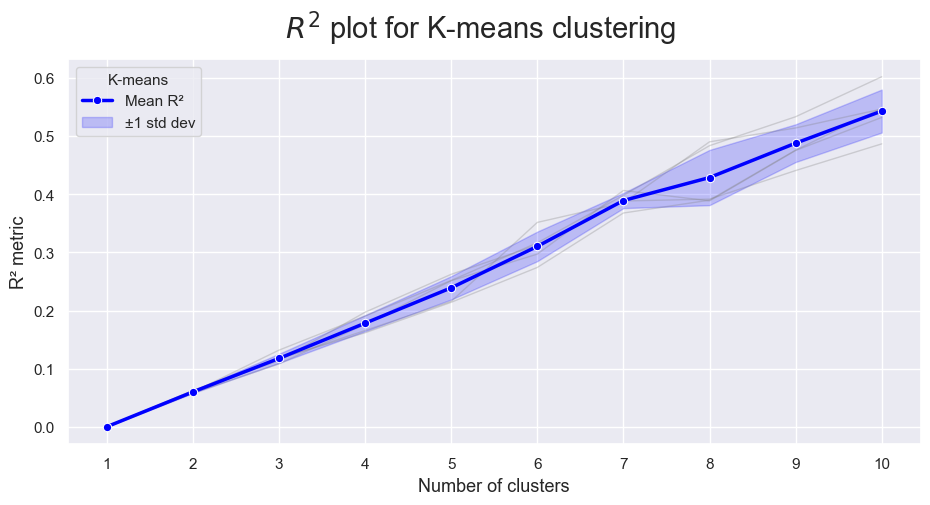

In [34]:
sns.set()

# Plot data
fig = plt.figure(figsize=(11,5))

# Plot individual initializations with lower alpha for less visual clutter
for i in range(n_initializations):
    plt.plot(r2_kmeans_df.index, r2_kmeans_df[f'init_{i}'], 
             alpha=0.3, color='gray', linestyle='-', linewidth=1)

# Plot mean with confidence band
sns.lineplot(data=r2_kmeans_df['mean_R2'], linewidth=2.5, marker='o', 
             label='Mean R²', color='blue')

# Add confidence band
plt.fill_between(r2_kmeans_df.index,
                 r2_kmeans_df['mean_R2'] - r2_kmeans_df['std_R2'],
                 r2_kmeans_df['mean_R2'] + r2_kmeans_df['std_R2'],
                 alpha=0.2, color='blue', label='±1 std dev')

# Finalize the plot
plt.legend(title="K-means", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R² metric", fontsize=13)

fig.suptitle("$R^2$ plot for K-means clustering", fontsize=21)

plt.show()

The elbow seems to exist with 2 or 4 clusters introduced.

Silhouette Coefficient

Measure how well represented each datapoint is by its cluster. Measure of how similar an object is to its own cluster compared to other clusters. The goal is to make sure to assign each datapoint to the correct cluster.

For n_clusters = 2, the average silhouette_score is : 0.3008398669609996
For n_clusters = 3, the average silhouette_score is : 0.31410787795218054
For n_clusters = 4, the average silhouette_score is : 0.35168839809768976
For n_clusters = 5, the average silhouette_score is : 0.35637074854900985
For n_clusters = 6, the average silhouette_score is : 0.3249649092331996
For n_clusters = 7, the average silhouette_score is : 0.3113967720684909
For n_clusters = 8, the average silhouette_score is : 0.3270527332467899
For n_clusters = 9, the average silhouette_score is : 0.32983441721721546
For n_clusters = 10, the average silhouette_score is : 0.34146326354467366


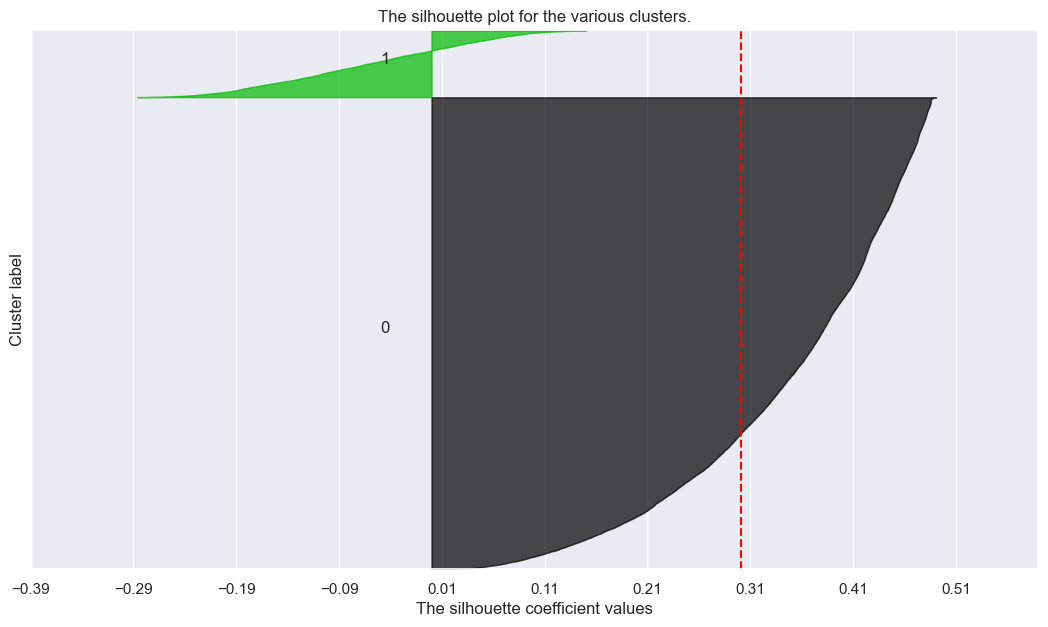

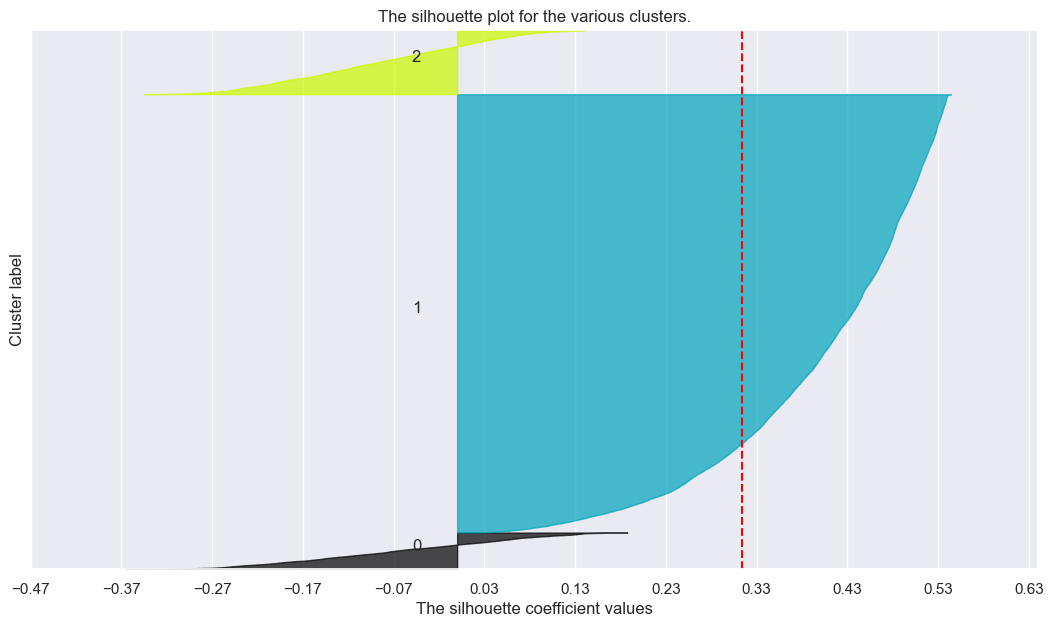

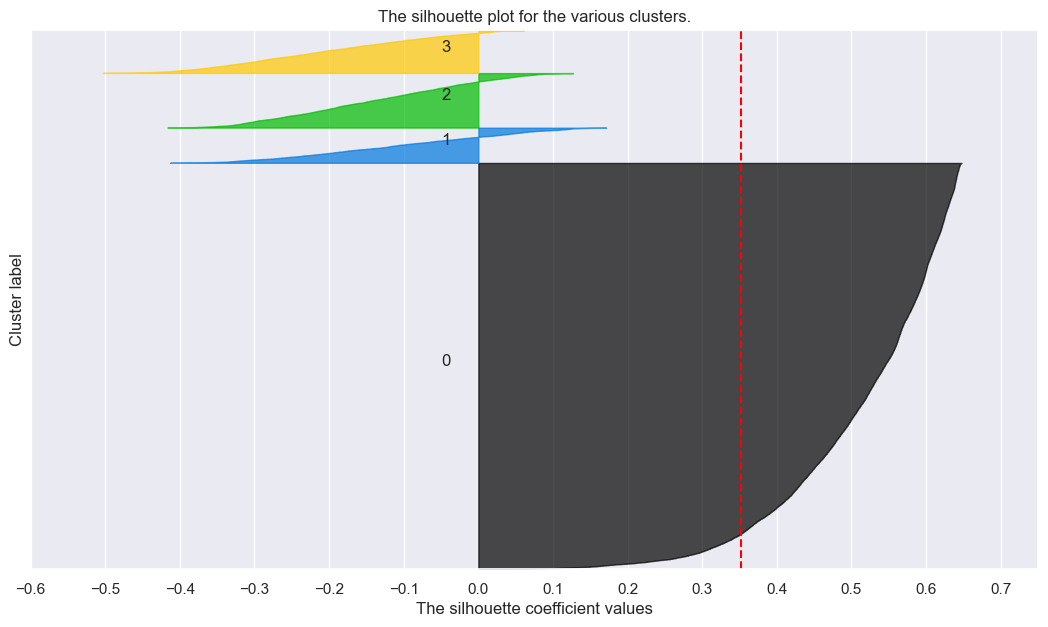

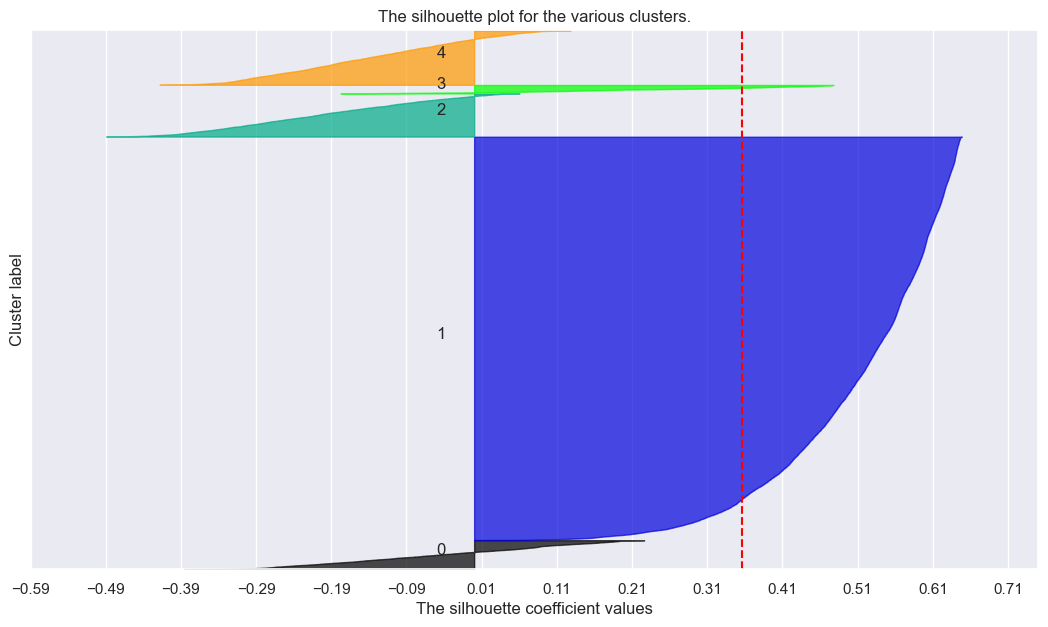

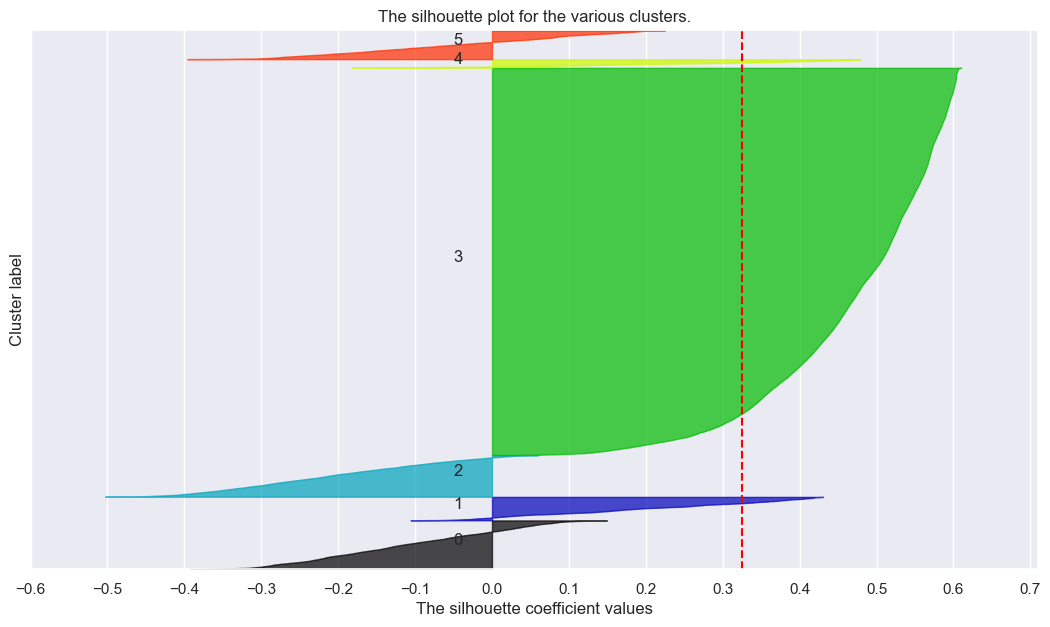

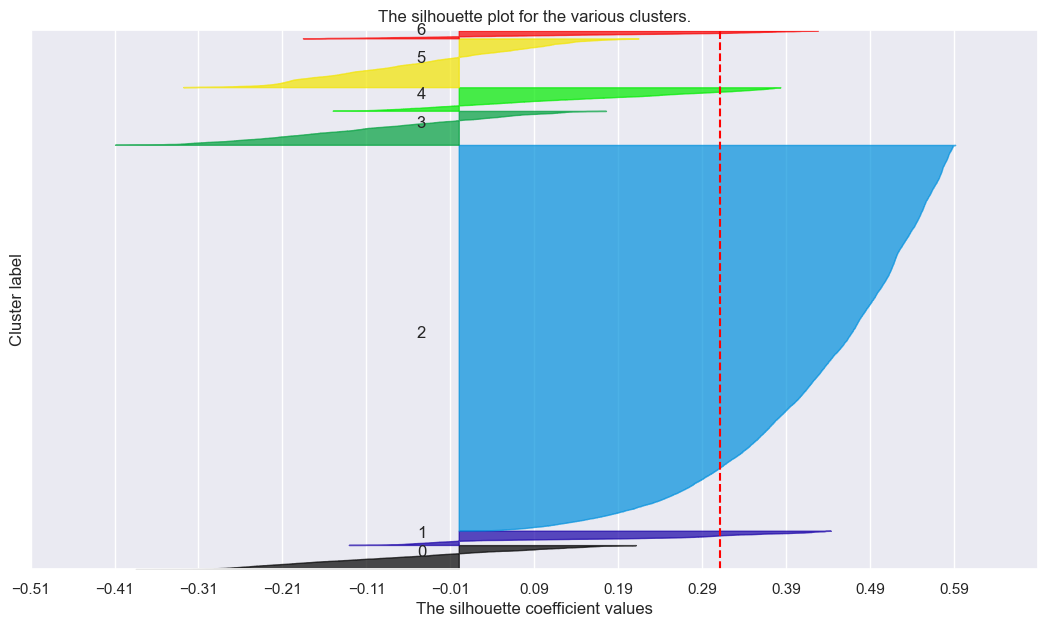

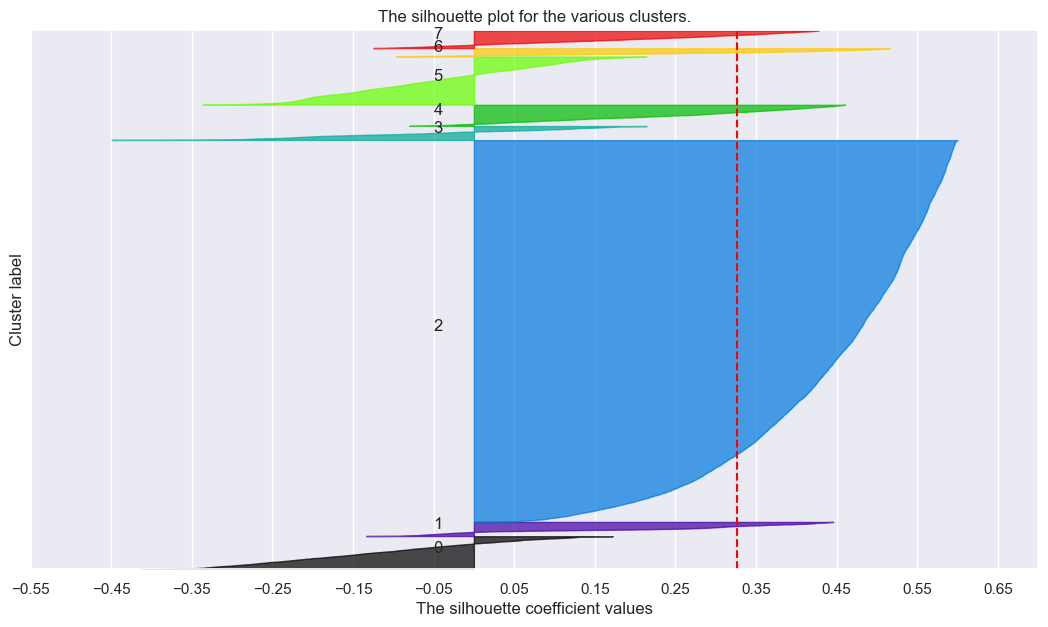

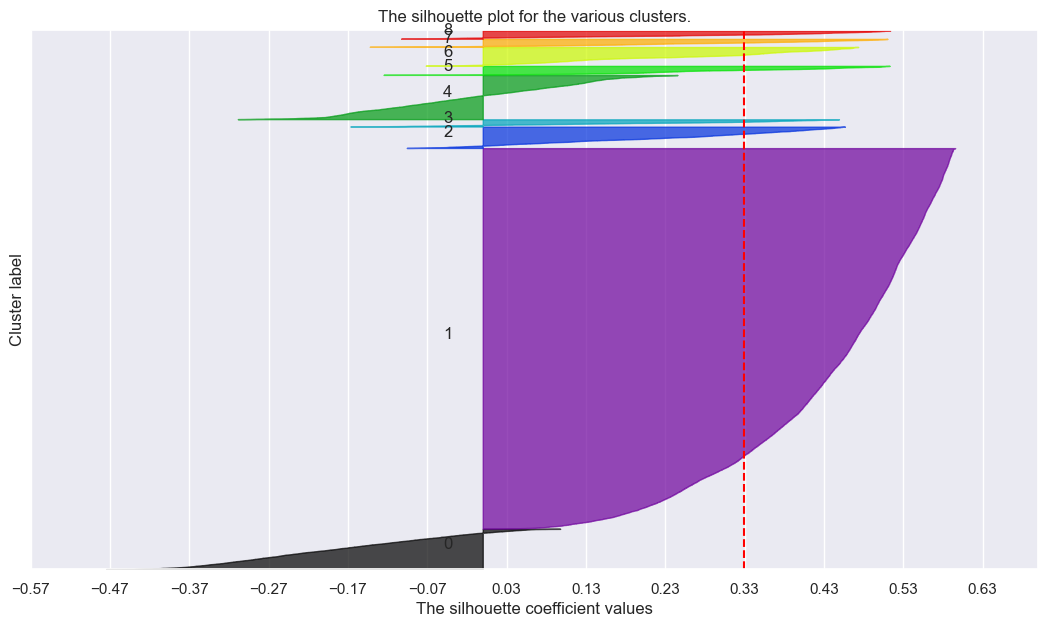

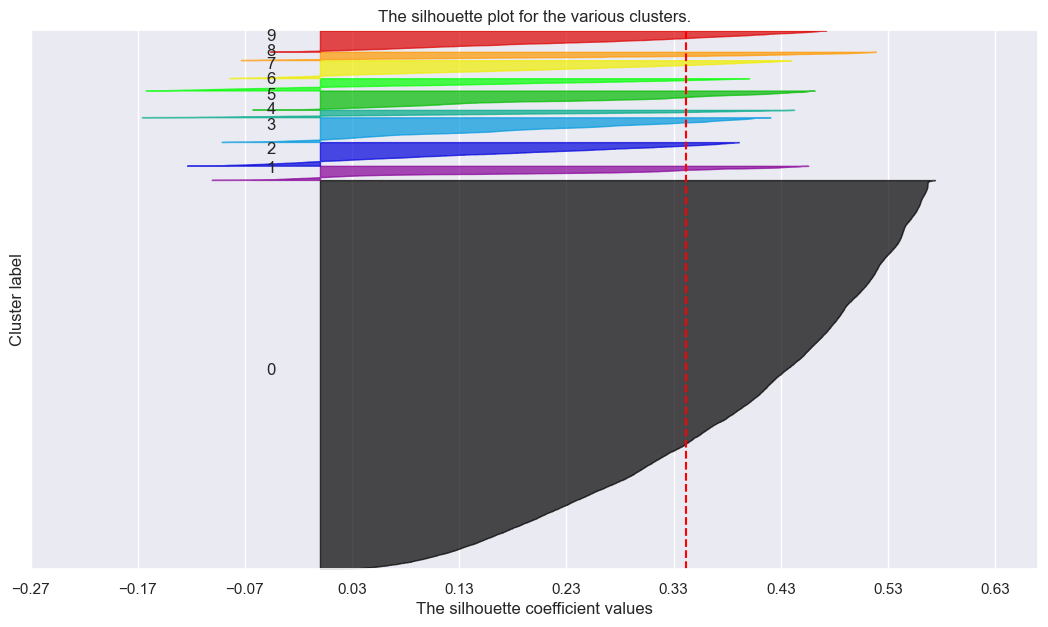

In [35]:
# Storing average silhouette metric
avg_silhouette = []
for nclus in range_clusters:
    # Skip nclus == 1
    if nclus == 1:
        continue
    
    # Create a figure
    fig = plt.figure(figsize=(13, 7))

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
    cluster_labels = kmclust.fit_predict(df_preferences)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(df_preferences, cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_preferences, cluster_labels)

    y_lower = 10
    for i in range(nclus):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        # Get y_upper to demarcate silhouette y range size
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Filling the silhouette
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # The silhouette coefficient can range from -1, 1
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    # The (nclus+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(df_preferences) + (nclus + 1) * 10])

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks(np.arange(xmin, xmax, 0.1))

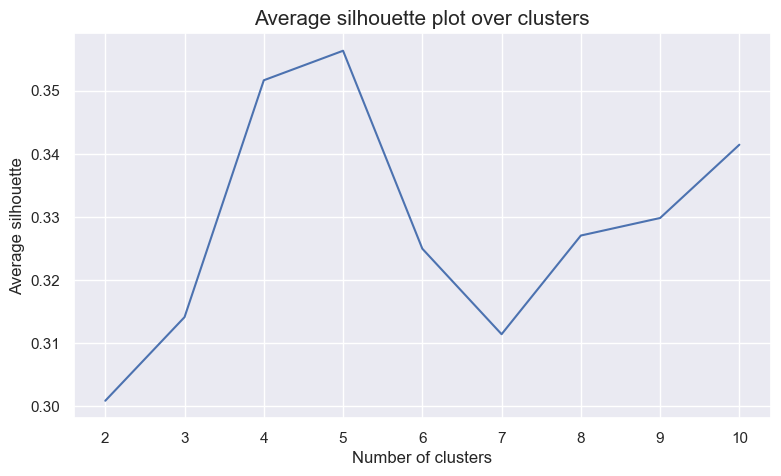

In [36]:
# The average silhouette plot
# The inertia plot
plt.figure(figsize=(9,5))


#  Why range_clusters[1:] ? 
# Remember we skipped k=1 in the cell above

plt.plot(range_clusters[1:], ## Plot X-axis; 
         avg_silhouette)     ## Plot Y-axis

plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

### Final K-Means Clustering Solution

In [37]:
number_clusters = 4
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=1)
km_labels = kmclust.fit_predict(df_preferences)
km_labels

array([0, 0, 0, ..., 2, 0, 0])

In [38]:
df_concat = pd.concat((df_preferences, pd.Series(km_labels, name='labels', index=df_preferences.index)), axis=1)
df_concat.groupby('labels').mean()


,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,CUI_Chicken Dishes,CUI_Chinese,CUI_Desserts,CUI_Healthy,CUI_Indian,CUI_Italian,CUI_Japanese,CUI_Noodle Dishes,CUI_OTHER,CUI_Street Food / Snacks,CUI_Thai
labels,,,,,,,,,,,,,,,
0,-0.039400,-0.173795,-0.074317,-0.102703,-0.157614,-0.106634,-0.134300,-0.011034,-0.089334,-0.107187,-0.034032,-0.108311,-0.111546,-0.153018,-0.113138
1,-0.184502,-0.304522,-0.009078,-0.097704,2.425398,1.477744,-0.089383,-0.123413,-0.039985,-0.208180,-0.098867,1.710634,0.274307,-0.216032,-0.013028
2,0.121059,1.671109,0.754288,-0.139441,-0.232941,-0.051356,1.181701,-0.008079,-0.225594,-0.296050,0.143561,-0.172329,-0.307133,1.458049,-0.192918
3,0.373544,-0.228868,-0.248625,1.240500,-0.195788,-0.133990,-0.156761,0.217550,1.175518,1.575056,0.222812,-0.155070,1.233010,-0.227453,1.338875


<a class="anchor" id="som">

## 3.3. SOM
</a>

Finding the best choice of parameters and training the SOM

In [20]:
def calculate_topographic_error(som, data):
    """Calculate the topographic error for a SOM."""
    errors = 0
    for sample in data:
        bmu_1 = som.winner(sample)  # Best Matching Unit (BMU 1)
        distances = np.linalg.norm(som._weights - sample, axis=-1)  # Distances to all nodes
        bmu_2 = np.unravel_index(np.argsort(distances.ravel())[1], distances.shape)  # BMU 2
        
        # Check if BMU 1 and BMU 2 are neighbors
        neighbors = som.get_neighbors(bmu_1)
        if bmu_2 not in neighbors:
            errors += 1
    
    return errors / len(data)

def get_neighbors_hexagonal(som, node):
    """Get hexagonal neighbors of a node in the SOM."""
    x, y = node
    neighbors = []
    for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (1, 1)]:
        nx, ny = x + dx, y + dy
        if 0 <= nx < som._weights.shape[0] and 0 <= ny < som._weights.shape[1]:
            neighbors.append((nx, ny))
    return neighbors

# Add neighbors function to MiniSom
MiniSom.get_neighbors = get_neighbors_hexagonal

def train_and_evaluate_som(data, M=30, N=30, learning_rate=0.5, sigma=3.0, neighborhood_function='gaussian', topology='hexagonal', random_seed=42):
    """Train a SOM and calculate QE and TE before and after training."""
    n_features = data.shape[1]
    som = MiniSom(M, N, n_features, sigma=sigma, learning_rate=learning_rate, 
                  neighborhood_function=neighborhood_function, topology=topology, random_seed=random_seed)
    
    # Initialize weights and evaluate before training
    som.random_weights_init(data)
    print("Before training:")
    qe_before = np.round(som.quantization_error(data), 4)
    te_before = np.round(calculate_topographic_error(som, data), 4)
    print(f"QE: {qe_before}, TE: {te_before}")
    
    # Train SOM
    som.train_batch(data, 20000)  # 20,000 iterations as an example
    
    # Evaluate after training
    print("After training:")
    qe_after = np.round(som.quantization_error(data), 4)
    te_after = np.round(calculate_topographic_error(som, data), 4)
    print(f"QE: {qe_after}, TE: {te_after}")
    
    return som, qe_before, te_before, qe_after, te_after



def run_multiple_soms(data, learning_rates, sigmas, M=30, N=30, iterations=20000, w1=1, w2=1):
    """Run SOM training for multiple configurations of learning rates and sigmas."""
    # Results container
    results_after = []
    
    print("Evaluating errors before training:")
    # Calculate and display errors before training (same for all configurations)
    n_features = data.shape[1]
    som = MiniSom(M, N, n_features, sigma=3.0, learning_rate=0.5, neighborhood_function='gaussian', topology='hexagonal', random_seed=42)
    som.random_weights_init(data)
    qe_before = np.round(som.quantization_error(data), 4)
    te_before = np.round(calculate_topographic_error(som, data), 4)
    print(f"QE Before Training: {qe_before}")
    print(f"TE Before Training: {te_before}")
    
    print("\nTraining SOMs for all configurations:")
    for lr in learning_rates:
        for sigma in sigmas:
            print(f"\nTraining SOM with learning_rate={lr}, sigma={sigma}")
            som = MiniSom(M, N, n_features, sigma=sigma, learning_rate=lr, neighborhood_function='gaussian', topology='hexagonal', random_seed=42)
            som.random_weights_init(data)
            som.train_batch(data, iterations)
            
            # Calculate and print errors after training
            qe_after = np.round(som.quantization_error(data), 4)
            te_after = np.round(calculate_topographic_error(som, data), 4)
            print(f"After Training - QE: {qe_after}, TE: {te_after}")
            
            # Store results
            results_after.append({
                'Learning Rate': lr,
                'Sigma': sigma,
                'QE After': qe_after,
                'TE After': te_after
            })

    # Convert results to DataFrame
    after_df = pd.DataFrame(results_after)

    # Compute combined score and identify the best configuration
    after_df['Score'] = w1 * after_df['QE After'] + w2 * after_df['TE After']
    best_config = after_df.loc[after_df['Score'].idxmin()]  # Get row with lowest score

    # Print best configuration
    print("\nBest Configuration:")
    print(f"Learning Rate: {best_config['Learning Rate']}, Sigma: {best_config['Sigma']}")
    print(f"QE After: {best_config['QE After']}, TE After: {best_config['TE After']}, Score: {best_config['Score']}")
    
    return after_df, best_config

Before training:


C:\Users\joana\anaconda3\Lib\site-packages\minisom.py:631: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)


QE: 0.8063, TE: 0.9963
After training:
QE: 0.948, TE: 0.2245


In [ ]:
# Dataset
M, N = 30, 30
som_data_preferences = df_preferences.values  # Your scaled dataset
input_len = som_data_preferences.shape[1]  # Number of features (4)

# SOM Initialization
som_c = MiniSom(M, N, input_len, sigma=3., learning_rate=2.5, random_seed=42, neighborhood_function='gaussian')
som_c.random_weights_init(som_data_preferences)

# Define plotting parameters
fig, axes = plt.subplots(2, 3, figsize=(14, 8), gridspec_kw={'hspace': .15}, constrained_layout=True, dpi=120)
colors_dims = (30, 30)
major_ticks = np.arange(0, M + 1, 5)
minor_ticks = np.arange(0, M + 1, 1)

################################
## Helper Function
################################
def tidy_ax(ax, major_ticks, minor_ticks, grid_size):
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which='both', color='gray', linestyle=':', linewidth=0.5)
    ax.set_xlim([0, grid_size])
    ax.set_ylim([0, grid_size])
    return ax

################################
## Random Weights
################################
ax = axes[0][0]
ax.imshow(abs(som_c.get_weights()).mean(axis=2), interpolation='none', origin="lower")  # Mean of weights for visualization
ax = tidy_ax(ax, major_ticks, minor_ticks, M)
qe = np.round(som_c.quantization_error(som_data_preferences), 3)
te = np.round(som_c.topographic_error(som_data_preferences), 3)
ax.set_title(f"SOM Random Weights\nQE:{qe} TE:{te}")

################################
## Trained SOM - 500 Iterations
################################
ax = axes[0][1]
som_c.train(som_data_preferences, 500, random_order=True, verbose=False)
ax.imshow(abs(som_c.get_weights()).mean(axis=2), interpolation='none', origin="lower", alpha=.75)  # Mean of weights
ax = tidy_ax(ax, major_ticks, minor_ticks, M)
qe = np.round(som_c.quantization_error(som_data_preferences), 3)
te = np.round(som_c.topographic_error(som_data_preferences), 3)
ax.set_title(f"SOM Trained 500 iters, sigma=3, LR=2.5\nQE:{qe} TE:{te}")

################################
## Fully Trained SOM
################################
ax = axes[0][2]
som_c.train(som_data_preferences, len(som_data_preferences), random_order=True, verbose=False)
ax.imshow(abs(som_c.get_weights()).mean(axis=2), interpolation='none', origin="lower", alpha=.75)  # Mean of weights
ax = tidy_ax(ax, major_ticks, minor_ticks, M)
qe = np.round(som_c.quantization_error(som_data_preferences), 3)
te = np.round(som_c.topographic_error(som_data_preferences), 3)
ax.set_title(f"SOM Trained N iters, sigma=3, LR=2.5\nQE:{qe} TE:{te}")

################################
## Other Configurations (Optional)
################################

# SOM with sigma=1
ax = axes[1][0]
som_c = MiniSom(M, N, input_len, sigma=1., learning_rate=2.5, random_seed=42, neighborhood_function='gaussian')
som_c.train(som_data_preferences, 500, random_order=True, verbose=False)
ax.imshow(abs(som_c.get_weights()).mean(axis=2), interpolation='none', origin="lower", alpha=.75)  # Mean of weights
ax = tidy_ax(ax, major_ticks, minor_ticks, M)
qe = np.round(som_c.quantization_error(som_data_preferences), 3)
te = np.round(som_c.topographic_error(som_data_preferences), 3)
ax.set_title(f"SOM Trained 500 iters, sigma=1, LR=2.5\nQE:{qe} TE:{te}")

# SOM with learning rate=1.5
ax = axes[1][1]
som_c = MiniSom(M, N, input_len, sigma=3., learning_rate=1.5, random_seed=42, neighborhood_function='gaussian')
som_c.train(som_data_preferences, 500, random_order=True, verbose=False)
ax.imshow(abs(som_c.get_weights()).mean(axis=2), interpolation='none', origin="lower", alpha=.75)  # Mean of weights
ax = tidy_ax(ax, major_ticks, minor_ticks, M)
qe = np.round(som_c.quantization_error(som_data_preferences), 3)
te = np.round(som_c.topographic_error(som_data_preferences), 3)
ax.set_title(f"SOM Trained 500 iters, sigma=3, LR=1.5\nQE:{qe} TE:{te}")

# Batch Trained SOM
ax = axes[1][2]
som_c = MiniSom(M, N, input_len, sigma=3., learning_rate=2.5, random_seed=42, neighborhood_function='gaussian')
som_c.train(som_data_preferences, 2, random_order=True, verbose=False)
ax.imshow(abs(som_c.get_weights()).mean(axis=2), interpolation='none', origin="lower", alpha=.75)  # Mean of weights
ax = tidy_ax(ax, major_ticks, minor_ticks, M)
qe = np.round(som_c.quantization_error(som_data_preferences), 3)
te = np.round(som_c.topographic_error(som_data_preferences), 3)
ax.set_title(f"SOM Batch Trained 2 iters/sample, sigma=3, LR=2.5\nQE:{qe} TE:{te}")

plt.show()


In [ ]:
# Apply function to your dataset
som_data_preferences = df_preferences.values  # Replace with your scaled dataset
som, qe_before, te_before, qe_after, te_after = train_and_evaluate_som(som_data_preferences)

In [21]:
# Define learning rates and sigmas to test
learning_rates = [0.3, 0.5, 0.7, 1.0]
sigmas = [1.0, 2.0, 3.0, 5.0]

# Run the experiments
results_after_df, best_config = run_multiple_soms(som_data_preferences, learning_rates, sigmas)


som_best_preferences = MiniSom(
    x=30, y=30, input_len=som_data_preferences.shape[1],
    sigma=best_config['Sigma'], learning_rate=best_config['Learning Rate'],
    neighborhood_function='gaussian', topology='hexagonal',
    random_seed=42
)
som_best_preferences.random_weights_init(som_data_preferences)
som_best_preferences.train_batch(som_data_preferences, 20000)  # Train for the desired number of iterations

Evaluating errors before training:
QE Before Training: 0.8063
TE Before Training: 0.9963

Training SOMs for all configurations:

Training SOM with learning_rate=0.3, sigma=1.0
After Training - QE: 0.7244, TE: 0.4363

Training SOM with learning_rate=0.3, sigma=2.0
After Training - QE: 0.8307, TE: 0.2554

Training SOM with learning_rate=0.3, sigma=3.0
After Training - QE: 0.9409, TE: 0.2043

Training SOM with learning_rate=0.3, sigma=5.0
After Training - QE: 1.1529, TE: 0.1851

Training SOM with learning_rate=0.5, sigma=1.0
After Training - QE: 0.7035, TE: 0.3992

Training SOM with learning_rate=0.5, sigma=2.0
After Training - QE: 0.8272, TE: 0.2407

Training SOM with learning_rate=0.5, sigma=3.0
After Training - QE: 0.948, TE: 0.2245

Training SOM with learning_rate=0.5, sigma=5.0
After Training - QE: 1.1681, TE: 0.1697

Training SOM with learning_rate=0.7, sigma=1.0
After Training - QE: 0.7156, TE: 0.4598

Training SOM with learning_rate=0.7, sigma=2.0
After Training - QE: 0.8306, TE: 

Visualizing the trained SOM of the preferences_df with the best found parameters

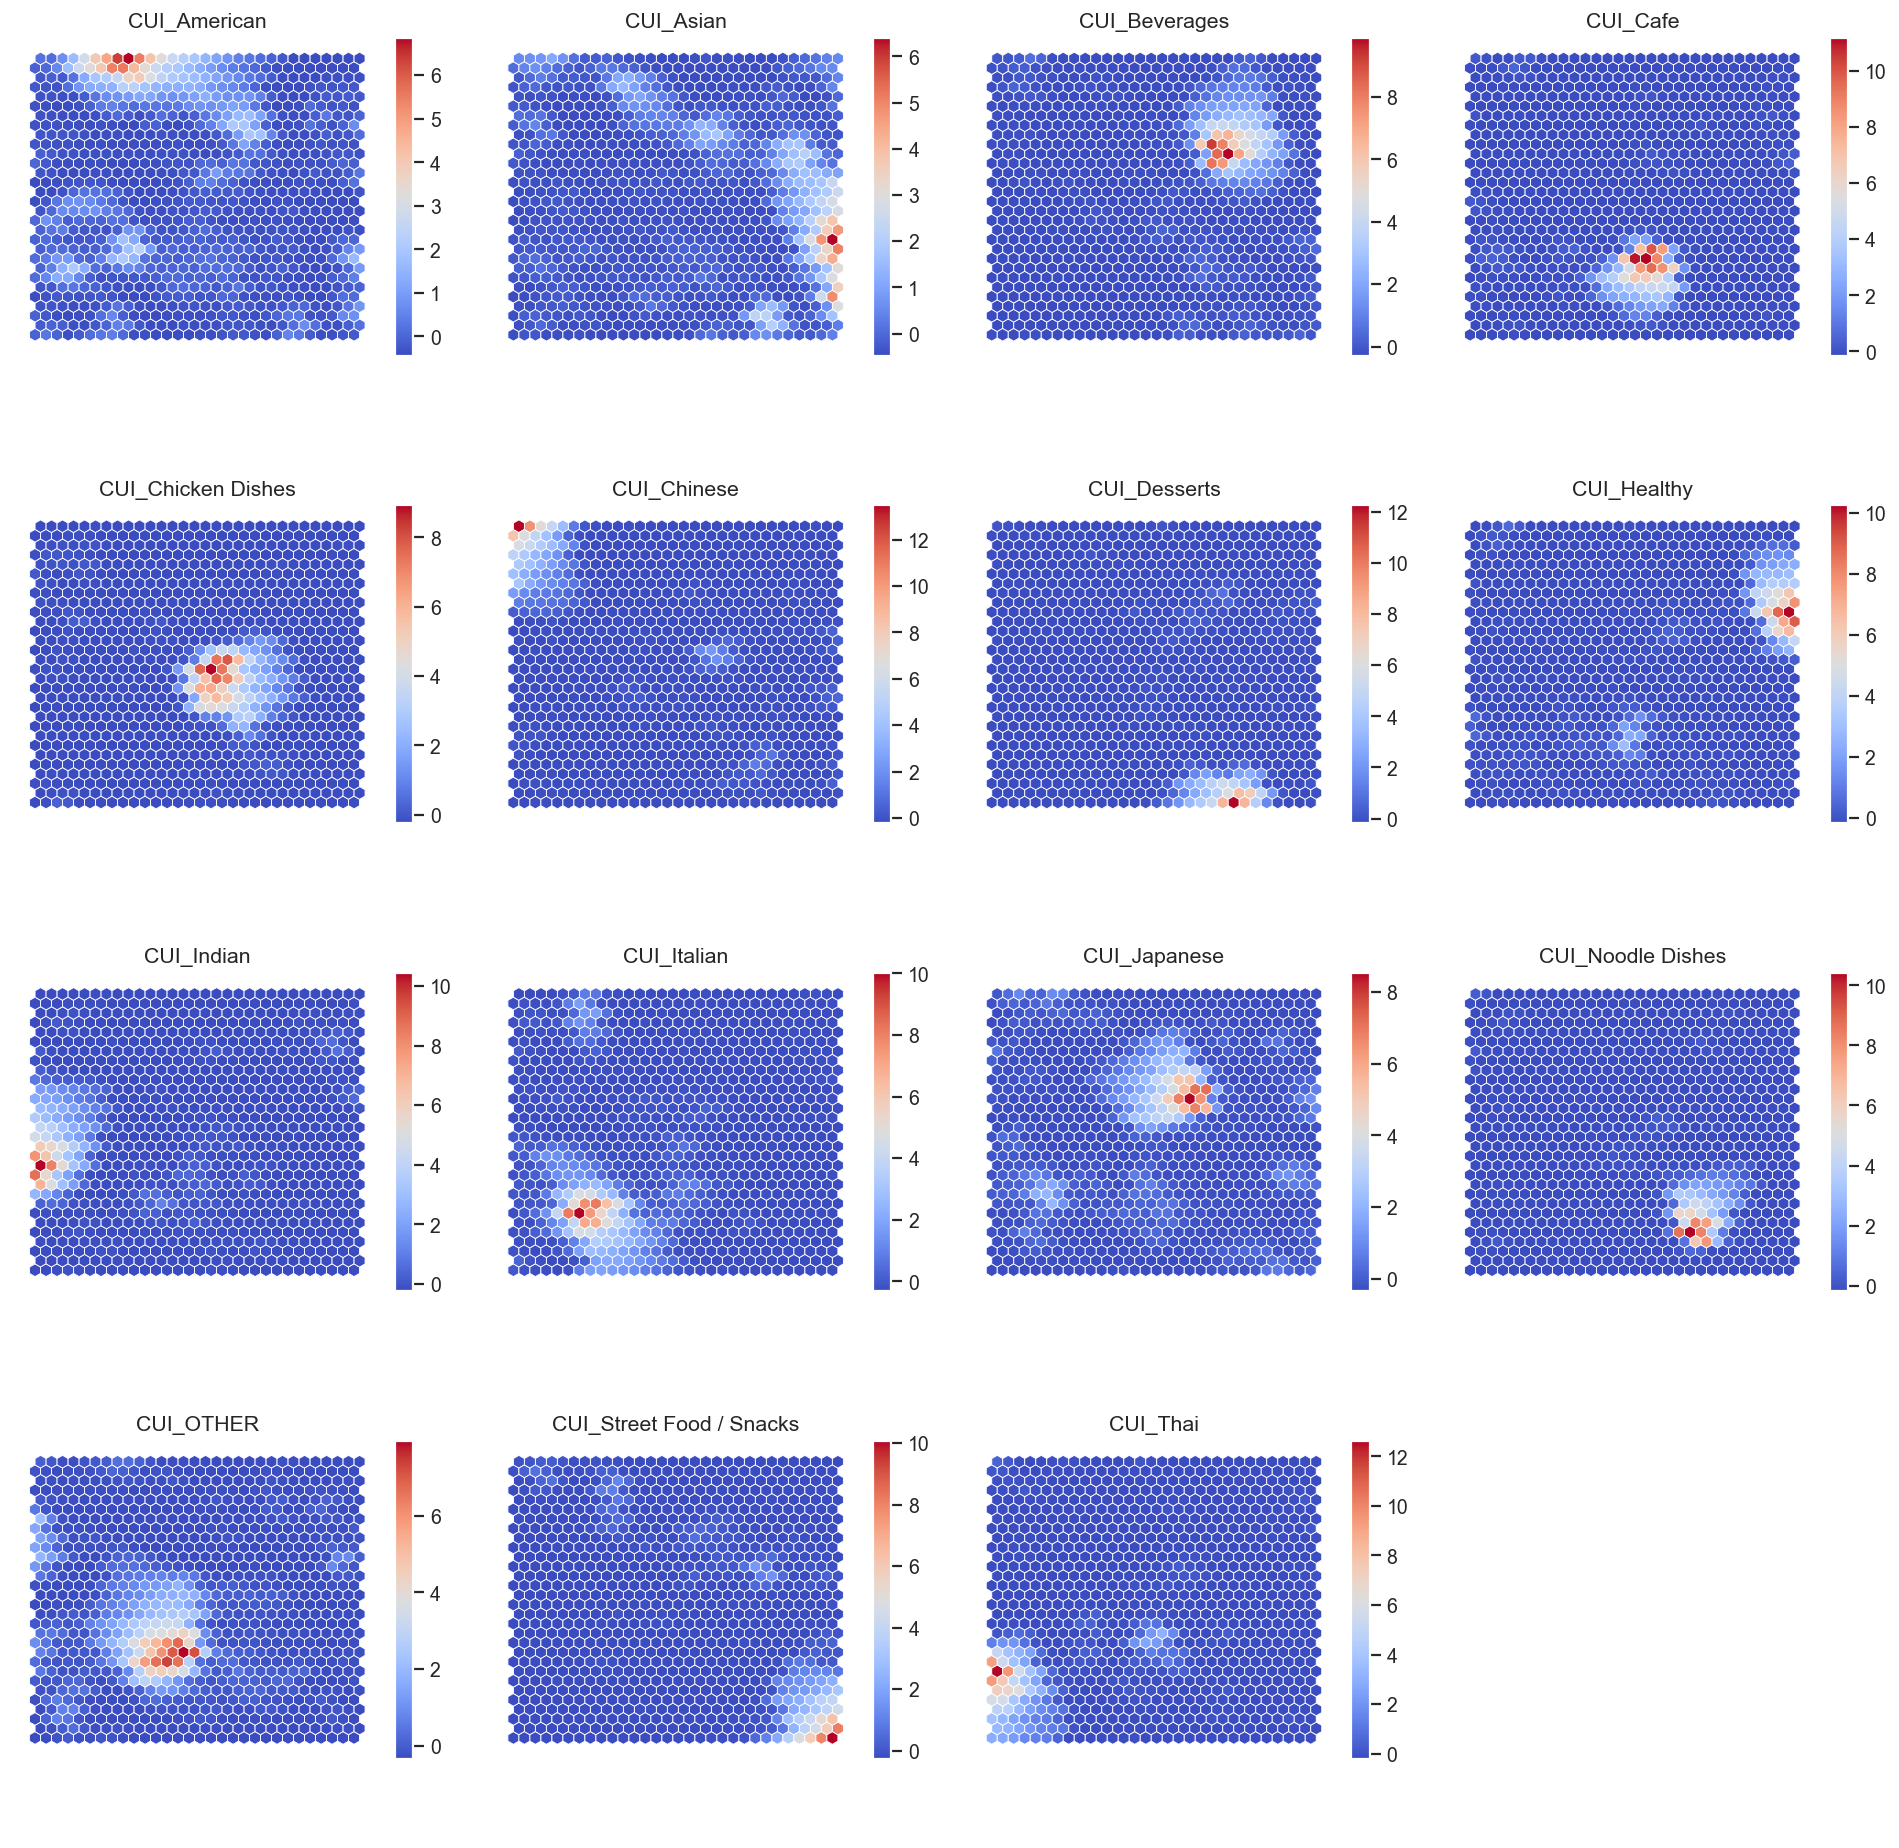

In [22]:
# Example plotting for 15 features (4x4 grid layout)
weights = som_best_preferences.get_weights()  # SOM weights
features_to_plot = df_preferences.columns  # All 15 features

# Create a grid layout that can accommodate all features (e.g., 4x4)
fig, axes = plt.subplots(4, 4, figsize=(15, 15), dpi=128)  # 4 rows, 4 columns
axes = axes.flatten()  # Flatten for easier indexing

for idx, ax in enumerate(axes):
    if idx < len(features_to_plot):  # Only plot for available features
        matrix_vals = weights[:, :, idx]
        colornorm = mpl_colors.Normalize(vmin=np.min(matrix_vals), vmax=np.max(matrix_vals))
        plot_hexagons(
            som_best_preferences,
            ax,
            colornorm,
            matrix_vals,
            label=features_to_plot[idx],
            cmap=cm.coolwarm,
        )
    else:  # Hide unused subplots
        ax.axis("off")

plt.tight_layout()
plt.show()


### U-matrix


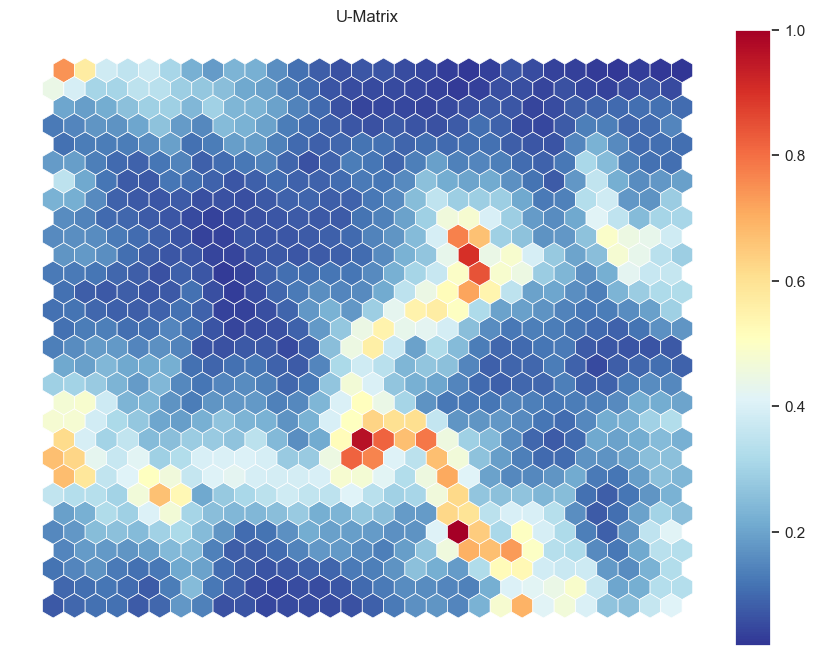

In [24]:
# Compute U-Matrix
umatrix = som_best_preferences.distance_map(scaling='mean')  # MiniSom's built-in U-Matrix computation

# Plot the U-Matrix
fig, ax = plt.subplots(figsize=(10, 8))  # Create a single Axes object
colornorm = mpl_colors.Normalize(vmin=np.min(umatrix), vmax=np.max(umatrix))

# Use the corrected plot_hexagons function
plot_hexagons(
    som_best_preferences,
    ax,  # Pass the Axes object, not the Figure
    colornorm,
    umatrix,
    label="U-Matrix",
    cmap=cm.RdYlBu_r  # Red-Blue colormap
    #annot=True,  # Annotate hexagons with U-Matrix values
)

plt.show()


### Hit-map


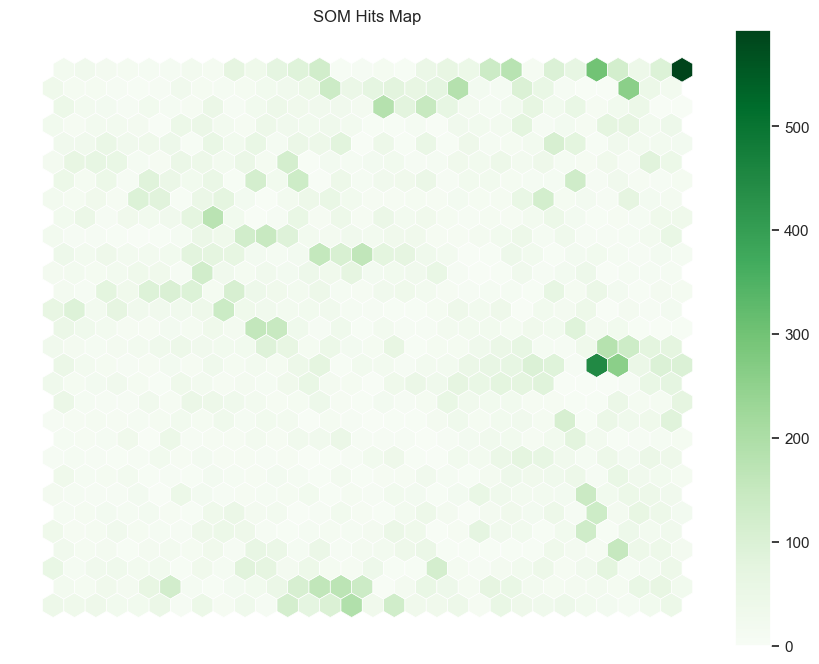

In [25]:
som_best_preferences = MiniSom(
    x=30, y=30, input_len=som_data_preferences.shape[1],
    sigma=best_config['Sigma'], learning_rate=best_config['Learning Rate'],
    neighborhood_function='gaussian', topology='hexagonal',
    random_seed=42
)
som_best_preferences.random_weights_init(som_data_preferences)
som_best_preferences.train_batch(som_data_preferences, 20000) 

# Compute Hits Map
hitsmatrix = som_best_preferences.activation_response(df_preferences.values)  # Get the hits matrix

# Create a figure and an Axes object for the heatmap
fig, ax = plt.subplots(figsize=(10, 8))  # Create a single subplot (Axes object)

# Normalize colors for the heatmap
colornorm = mpl_colors.Normalize(vmin=0, vmax=np.max(hitsmatrix))

# Plot the Hits Map using your plot_hexagons function
plot_hexagons(
    som_best_preferences,
    ax,  # Pass the Axes object, not the Figure
    colornorm,
    hitsmatrix,
    label="SOM Hits Map",
    cmap=cm.Greens,  # Green colormap
    #annot=True,  # Annotate with the number of hits
)

plt.show()


### K-Means on top of SOM units

In [26]:
# Flatten the SOM weights
weights_flat_preferences = som_best_preferences.get_weights().reshape((30 * 30), 15)
print("Flattened SOM weights shape:", weights_flat_preferences.shape)

Flattened SOM weights shape: (900, 15)


In [27]:
# Perform K-Means clustering
n_clusters = 4  # Define the number of clusters
kmeans_preferences = KMeans(n_clusters=n_clusters, init='k-means++', n_init=20, random_state=42)
nodeclus_labels_preferences = kmeans_preferences.fit_predict(weights_flat_preferences)

# Reshape the cluster labels back to the SOM grid
kmeans_matrix_preferences = nodeclus_labels_preferences.reshape((30, 30))
print("K-Means clustering completed.")


K-Means clustering completed.


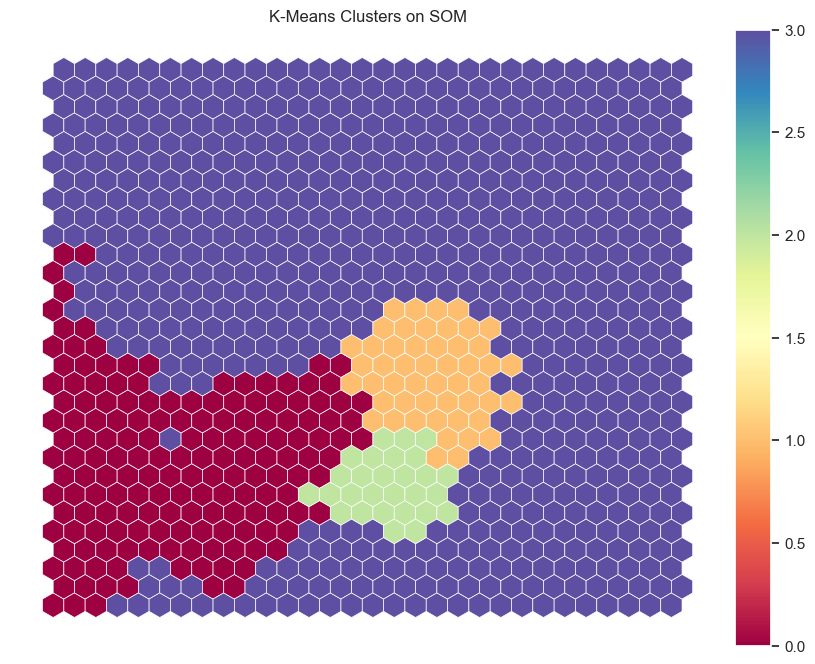

In [28]:
# Create a figure and an Axes object
fig, ax = plt.subplots(figsize=(10, 8))

# Normalize the color range for clusters
colornorm = mpl_colors.Normalize(vmin=0, vmax=n_clusters - 1)

# Plot the K-Means clustering results
plot_hexagons(
    som_best_preferences,
    ax,
    colornorm,
    kmeans_matrix_preferences,
    label="K-Means Clusters on SOM",
    cmap=cm.Spectral,  # Use a suitable colormap
)
plt.show()


### Hierarchical Clustering on top of SOM units

In [ ]:
from scipy.cluster.hierarchy import linkage, fcluster

# Compute pairwise distances and linkage matrix
linkage_matrix_preferences = linkage(weights_flat_preferences, method='ward', metric='euclidean')

# Assign clusters based on the linkage matrix
n_clusters = 4
hierarchical_labels_preferences = fcluster(linkage_matrix_preferences, n_clusters, criterion='maxclust')

# Reshape the cluster labels back to the SOM grid
hierarchical_matrix_preferences = hierarchical_labels_preferences.reshape((30, 30))
print("Hierarchical clustering completed.")

# Create a figure and an Axes object
fig, ax = plt.subplots(figsize=(10, 8))

# Normalize the color range for clusters
colornorm = mpl_colors.Normalize(vmin=1, vmax=n_clusters)

# Plot the hierarchical clustering results
plot_hexagons(
    som_best_preferences,
    ax,
    colornorm,
    hierarchical_matrix_preferences,
    label="Hierarchical Clusters on SOM",
    cmap=cm.Spectral,  # Use a suitable colormap
)
plt.show()


In [ ]:
from scipy.cluster.hierarchy import dendrogram

# Plot the dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix_preferences, truncate_mode='level', p=10)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("SOM Units")
plt.ylabel("Distance")
plt.show()


In [ ]:
nodes_preferences = weights_flat_preferences

In [ ]:
df_nodes_preferences = pd.DataFrame(nodes_preferences, columns=df_preferences.columns)
df_nodes_preferences['label'] = nodeclus_labels_preferences
df_nodes_preferences

In [ ]:
## This gets BMU coordinates, e.g. (4,4) for each data point
bmu_index_preferences = np.array([som_best_preferences.winner(x) for x in df_preferences.values])

print(bmu_index_preferences.shape)

bmu_index_preferences

In [ ]:

## This gets the cluster label from hclust_matrix, i.e.
## if data row 0 has BMU at (37, 28) 
## it will get the label associated to node (37,28) using label associated to hclust_matrix[37,28] above

som_final_labels_preferences = [hierarchical_matrix_preferences[i[0]][i[1]] for i in bmu_index_preferences]


In [ ]:
df_final_preferences = pd.concat([
                df_preferences,
                pd.Series(som_final_labels_preferences, name='label', index=df_preferences.index)
            ], axis=1
            )

df_final_preferences

In [ ]:
df_final_preferences[df_preferences.columns.tolist()+['label']].groupby('label').mean()

<a class="anchor" id="mean">

## 3.4. Mean Shift Clustering
</a>

In [ ]:
# The following bandwidth can be automatically detected using 
# # (we need to set quantile though)
# Based on distance to nearest neighbors for all observations

bandwidth = estimate_bandwidth(df_preferences, quantile=0.06, random_state=1, n_jobs=-1)
bandwidth
# Perform mean-shift clustering with bandwidth set using estimate_bandwidth
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=4)
ms_labels = ms.fit_predict(df_preferences)
ms_n_clusters = len(np.unique(ms_labels))
print("Number of estimated clusters : %d" % ms_n_clusters)

In [ ]:
# Perform mean-shift clustering with bandwidth set using estimate_bandwidth
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=4)
ms_labels = ms.fit_predict(df_preferences)
ms_n_clusters = len(np.unique(ms_labels))
print("Number of estimated clusters : %d" % ms_n_clusters)

In [ ]:
# Dúvida --> too many estimated clusters

The number of estimated clusters in mean-shift clustering can be influenced by several factors:

Bandwidth Parameter: The bandwidth parameter is crucial in mean-shift clustering. It determines the radius of the region used to compute the mean shift. If the bandwidth is too small, the algorithm may identify many small clusters, leading to a high number of estimated clusters. Conversely, a larger bandwidth may result in fewer clusters.

Data Distribution: The inherent distribution of your data can also affect the number of clusters. If your data has many dense regions, the mean-shift algorithm will identify each of these regions as a separate cluster.

Feature Selection: The features used for clustering (metric_features in this case) play a significant role. If the selected features have high variability or many distinct patterns, the algorithm may detect more clusters.

Noise and Outliers: The presence of noise and outliers in your data can lead to the identification of additional clusters. Mean-shift clustering is sensitive to such anomalies, which can increase the number of clusters.

To reduce the number of estimated clusters, you can try the following:

Adjust the Bandwidth: Increase the bandwidth parameter to merge nearby clusters.
Data Preprocessing: Normalize or standardize your data to reduce variability.
Feature Selection: Carefully select or reduce the number of features used for clustering.
Outlier Removal: Remove or handle outliers in your data before clustering.
You can experiment with these adjustments to find a more suitable number of clusters for your specific dataset.

In [ ]:
df_preferences_labels = pd.concat([df_preferences, pd.Series(ms_labels, index=df.index, name="ms_labels")], axis=1)
df_preferences_labels.head()

<a class="anchor" id="dbscan">

## 3.5. DBSCAN
</a>

In [ ]:
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=1.9, min_samples=20, n_jobs=4)
dbscan_labels = dbscan.fit_predict(df_preferences)

dbscan_n_clusters = len(np.unique(dbscan_labels))
print("Number of estimated clusters : %d" % dbscan_n_clusters)

In [ ]:
# K-distance graph to find out the right eps value
neigh = NearestNeighbors(n_neighbors=20)
neigh.fit(df_preferences[metric_features])
distances, _ = neigh.kneighbors(df_preferences)
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.show()

In [ ]:
# Concatenating the labels to df
df_preferences_labels = pd.concat([df_preferences, pd.Series(dbscan_labels, index=df.index, name="dbscan_labels")], axis=1)
df_preferences_labels.head()

In [ ]:
# Detecting noise (potential outliers)
df_preferences_labels.loc[df_preferences_labels['dbscan_labels'] == -1]

In [ ]:
# Computing the R^2 of the cluster solution
df_nonoise = df_preferences_labels.loc[df_preferences_labels['dbscan_labels'] != -1]
sst = get_ss(df_preferences[metric_features])  # get total sum of squares
ssw_labels = df_nonoise.groupby(by='dbscan_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

<a class="anchor" id="hierarchical">

## 3.6. GMM (Gaussian Mixture Model)
</a>


In [ ]:
# Performing GMM clustering
gmm = GaussianMixture(n_components=4, covariance_type='full', n_init=10, init_params='kmeans', random_state=1)
gmm_labels = gmm.fit_predict(df_preferences)
labels_proba = gmm.predict_proba(df_preferences)

Estimated Parameters:

In [ ]:
# The estimated component weights
gmm.weights_

In [ ]:
# The estimated mean vectors of the Components
print(gmm.means_.shape)
gmm.means_

In [ ]:
# The estimated covariance matrices of the Components
gmm.covariances_.shape

### Defining n_components:

In [ ]:
# This may take a while to run
# 
# Selecting number of components based on AIC and BIC
n_components = np.arange(1, 16)
models = [GaussianMixture(n, covariance_type='full', n_init=10, random_state=1).fit(df_preferences)
          for n in n_components]

bic_values = [m.bic(df_preferences) for m in models]
aic_values = [m.aic(df_preferences) for m in models]
plt.plot(n_components, bic_values, label='BIC')
plt.plot(n_components, aic_values, label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.xticks(n_components)
plt.show()

In [ ]:
# Concatenating the labels to df
df_preferences_labels = pd.concat([df_preferences, pd.Series(gmm_labels, index=df.index, name="gmm_labels")], axis=1)
df_preferences_labels.head()

In [ ]:
# Performing GMM clustering
gmm = GaussianMixture(n_components=3, covariance_type='full', n_init=10, init_params='kmeans', random_state=1)
gmm_labels = gmm.fit_predict(df_preferences)

<a class="anchor" id="density">

## 3.7. Density Based Clustering
</a>

In [ ]:
# ? concat things from SOM onwards into df_contact? ( keep a df that has everything )
# ? metric features = numeric_columns right? not numeric_columns_complet (might generate confusion)

In [ ]:
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift, DBSCAN, estimate_bandwidth

In [ ]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable